In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import re
import string
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/religion/Text based Religion Posts 35000.csv


In [2]:

def getSentences(text):
    nlp = English()
    nlp.add_pipe('sentencizer')
    document = nlp(text)
    return [sent.text.strip() for sent in document.sents]
def printToken(token):
    print(token.text, "->", token.dep_)
    
def appendChunk(original, chunk):
    return original + ' ' + chunk
def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)
def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)
def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                 subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''
            
    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())


def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

In [3]:
df = pd.read_csv(r'/kaggle/input/religion/Text based Religion Posts 35000.csv')
df.head()

,index,Document,subreddit
0,527941,"I was raised as a Muslim, but never got into t...",islam
1,534235,"\nAs salamu alaikum, I wonder what the benefit...",islam
2,531104,I was at a coffee shop when I saw a carbonara ...,islam
3,525922,"Hello, so I am a 13 year old boy, naturally I ...",islam
4,523640,We intend to get married soon but my father an...,islam


In [4]:
df.shape

(35000, 3)

In [5]:
df['subreddit'].value_counts()

subreddit
islam              11000
Christianity        4000
atheism             4000
hinduism            4000
exmuslim            2000
Muslim              1000
food                 700
Pets                 700
gaming               700
personalfinance      700
travel               700
Fitness              700
politics             700
sports               700
AskReddit            600
science              600
television           600
technology           600
MuslimMarriage       500
Hijabis              500
Name: count, dtype: int64

In [6]:
df.isnull().sum()

index        0
Document     0
subreddit    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df = df.drop('subreddit' , axis = 1)
df = df.drop('index' , axis = 1)

In [9]:
df

,Document
0,"I was raised as a Muslim, but never got into t..."
1,"\nAs salamu alaikum, I wonder what the benefit..."
2,I was at a coffee shop when I saw a carbonara ...
3,"Hello, so I am a 13 year old boy, naturally I ..."
4,We intend to get married soon but my father an...
...,...
34995,"You never hear of the Lord Shiva, for example,..."
34996,**Question 1 : What is the difference between ...
34997,"The symbol right now is associated with hate, ..."
34998,\n\nNamaste dear all \n \n\nI am really rea...


In [10]:
def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G,k=2, iterations=50)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=5000, node_color='lightblue', alpha=0.9,font_size=10,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()

In [11]:
def clean_text(x):
    text = re.sub('(\d+)','',x)   
    text = text.lower()
    return text
def remove_url(x):
    text = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})\/([a-zA-Z0-9_]+]*)',' ',x)
    return text
def remove_punct(x):
    text_without_puct = [t for t in x if t not in string.punctuation]
    text_without_puct = ''.join(text_without_puct)
    return text_without_puct
stop_words = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['Document'] = df['Document'].apply(clean_text)
df['Document'] = df['Document'].apply(remove_url)
df['Document'] = df['Document'].apply(remove_punct)
df['Document'] = df['Document'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [12]:
text = df['Document'].tolist()
read_1 = text[:10]
read_1

['raised muslim never got habit praying five times day strong believer try follow much lifestyle recommended like lying gossiping helping anyone possible basically trying good human general also try understand islam deeply reading looking resources discussing friends etc trying become better muslim better person moved new country extremely stressed time due engineering degree signs adhd childhood moving stress manifested stronger symptoms trouble day day life seeing counsellor figure actually adhd possible diagnosis also trying say prayers looking towards allah guidance salah cant focus mind recite quran everything needs done salah quiet time brain goes autopilot mode time things without even thinking led forgetting lot rakah different ideas sometimes even daydreaming something else salah worst missing imams instruction jamaat even idea post came mind salah led lose interest saying prayers multiple times tried get habit saying prayers daily multiple times days cant seem follow get frus

raised -> advcl
muslim -> dobj
never -> neg
got -> ccomp
habit -> dobj
praying -> acl
five -> nummod
times -> compound
day -> npadvmod
strong -> amod
believer -> nsubj
try -> aux
follow -> ccomp
much -> amod
lifestyle -> dobj
recommended -> acl
like -> prep
lying -> pcomp
gossiping -> xcomp
helping -> advcl
anyone -> nsubj
possible -> amod
basically -> advmod
trying -> ccomp
good -> amod
human -> amod
general -> dobj
also -> advmod
try -> conj
understand -> xcomp
islam -> nsubj
deeply -> advmod
reading -> ccomp
looking -> amod
resources -> dobj
discussing -> acl
friends -> dobj
etc -> cc
trying -> xcomp
become -> xcomp
better -> advmod
muslim -> amod
better -> amod
person -> nsubj
moved -> conj
new -> amod
country -> dobj
extremely -> advmod
stressed -> conj
time -> npadvmod
due -> amod
engineering -> compound
degree -> compound
signs -> compound
adhd -> compound
childhood -> nmod
moving -> amod
stress -> nsubj
manifested -> ccomp
stronger -> amod
symptoms -> dobj
trouble -> dobj
day -

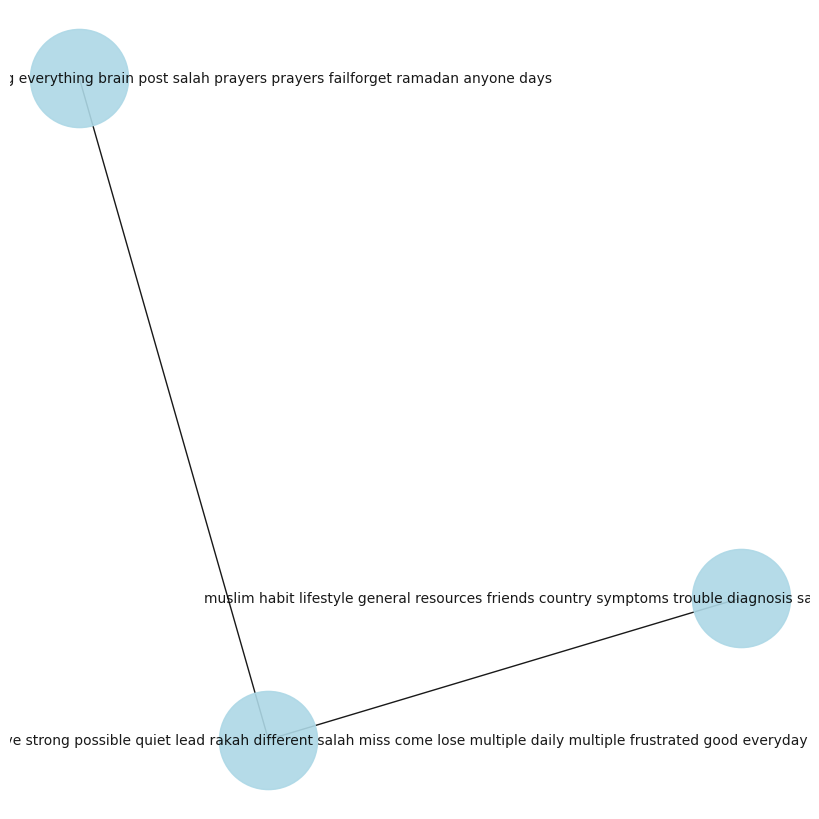

salamu -> amod
alaikum -> compound
wonder -> compound
benefits -> nsubj
umrah -> compound
hajj -> compound
people -> nsubj
takes -> relcl
long -> amod
time -> dobj
save -> advmod
required -> amod
money -> dobj
would -> aux
nt -> neg
first -> advmod
save -> ROOT
hajj -> dobj
umrah -> nsubj
later -> advmod
afford -> aux
know -> xcomp
many -> amod
countries -> dobj
hajj -> nsubj
easily -> advmod
accessible -> relcl
wait -> ccomp
relatively -> advmod
long -> advmod
queue -> acomp
one -> nummod
thing -> nsubj
would -> aux
understand -> ccomp
get -> xcomp
know -> amod
procedure -> compound
everything -> dobj
umrah -> xcomp
better -> advmod
prepared -> amod
hajj -> compound
thanks -> compound
contributions -> dobj
that -> nsubj
s -> relcl
pillar -> attr
know -> advmod
least -> advmod
hence -> advmod
question -> conj
benefits people umrah hajj thing that , salamu long require save many know prepare pillar , time money hajj countries everything contributions


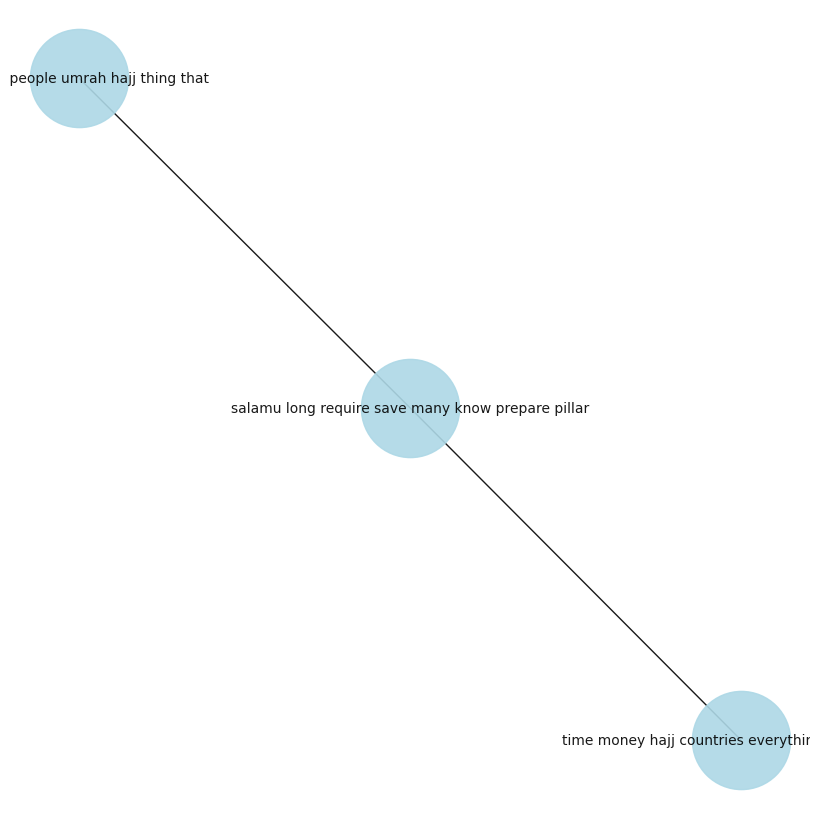

In [13]:
if __name__ == "__main__":
    text = 'raised muslim never got habit praying five times day strong believer try follow much lifestyle recommended like lying gossiping helping anyone possible basically trying good human general also try understand islam deeply reading looking resources discussing friends etc trying become better muslim better person moved new country extremely stressed time due engineering degree signs adhd childhood moving stress manifested stronger symptoms trouble day day life seeing counsellor figure actually adhd possible diagnosis also trying say prayers looking towards allah guidance salah cant focus mind recite quran everything needs done salah quiet time brain goes autopilot mode time things without even thinking led forgetting lot rakah different ideas sometimes even daydreaming something else salah worst missing imams instruction jamaat even idea post came mind salah led lose interest saying prayers multiple times tried get habit saying prayers daily multiple times days cant seem follow get frustrated failforget lose interest pray best ramadan prayed everyday days anyone give advice mindful salah build habit really dont know trying enough want better mindful stuff really hard feeling helpless days go'
    text1 = 'salamu alaikum wonder benefits umrah hajj people takes long time save required money wouldnt first save hajj umrah later afford know many countries hajj easily accessible wait relatively long queue one thing would understand get know procedure everything umrah better prepared hajj thanks contributions thats pillar know least hence question'
    sentences = getSentences(text)
    
    nlp_model = spacy.load('en_core_web_sm')

    triples = []
    for sentence in sentences:
        triples.append(processSentence(sentence))
        
    printGraph(triples)
    nlp_model = spacy.load('en_core_web_sm')
    sentences = getSentences(text1)

    triples = []
    for sentence in sentences:
        triples.append(processSentence(sentence))    
    printGraph(triples)    
        